In [ ]:
!pip install librosa soundfile webrtcvad numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73496 sha256=1c6ee875f03674fdb654795f471c555bb2a48f70a42a1c5e72181d3db706ae16
  Stored in directory: /root/.cache/pip/wheels/94/65/3f/292d0b656be33d1c801831201c74b5f68f41a2ae465ff2ee2f
Successfully built webrtcvad


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import webrtcvad
import time

<ipython-input-10-e732b159ce85>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-10-e732b159ce85>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-10-e732b159ce85>:42: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audiorea

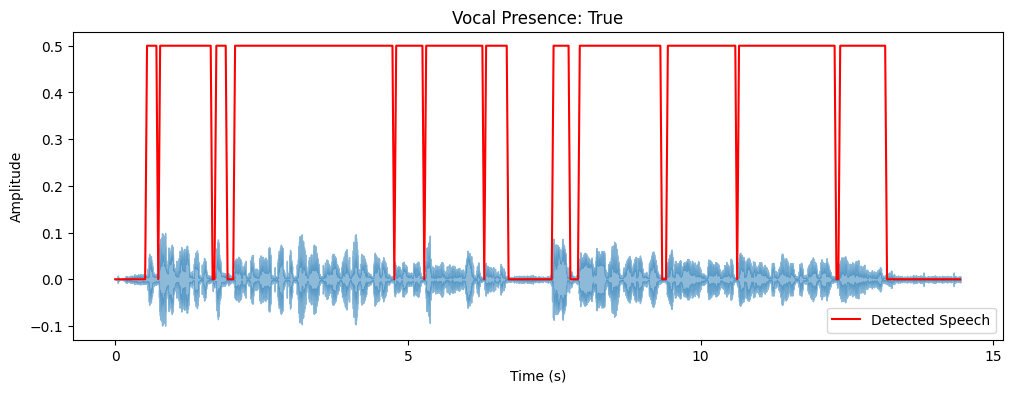

Vocal content detected: True


<ipython-input-10-e732b159ce85>:80: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=file_path)
<ipython-input-10-e732b159ce85>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-10-e732b159ce85>:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1

Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0002
   - Average RMS: 0.0125
   - Zero-Crossing Rate: 0.0311 (std: 0.0324)

2. Spectral Features:
   - Spectral Centroid: 686.99 Hz (std: 459.64)
   - Spectral Rolloff (85%): 1286.88 Hz
   - Energy Entropy: 0.0025

3. Performance Metrics:
   - Audio Duration: 14.40 seconds
   - Total Processing Time: 0.38 seconds
   - Real-Time Factor (RTF): 0.03
   - Processing Speed: 37.70x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/friend_eng1.m4a'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/friend_eng1.m4a')

<ipython-input-12-200f3412b39f>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-12-200f3412b39f>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-12-200f3412b39f>:42: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audiorea

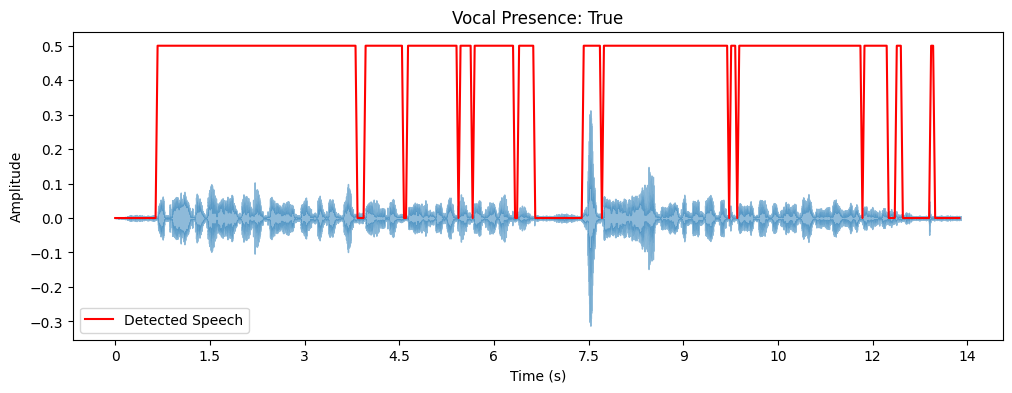

Vocal content detected: True


<ipython-input-12-200f3412b39f>:80: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=file_path)
<ipython-input-12-200f3412b39f>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-12-200f3412b39f>:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1

Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0003
   - Average RMS: 0.0130
   - Zero-Crossing Rate: 0.0292 (std: 0.0235)

2. Spectral Features:
   - Spectral Centroid: 664.80 Hz (std: 368.35)
   - Spectral Rolloff (85%): 1220.68 Hz
   - Energy Entropy: 0.0034

3. Performance Metrics:
   - Audio Duration: 13.40 seconds
   - Total Processing Time: 0.33 seconds
   - Real-Time Factor (RTF): 0.02
   - Processing Speed: 40.47x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/friend_eng2.m4a'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/friend_eng2.m4a')

<ipython-input-13-b58922b2bff5>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-13-b58922b2bff5>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-13-b58922b2bff5>:42: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audiorea

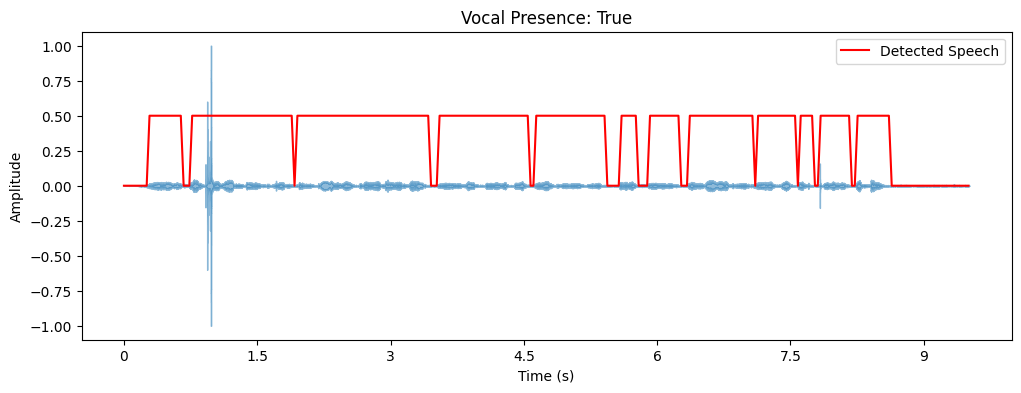

Vocal content detected: True


<ipython-input-13-b58922b2bff5>:80: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=file_path)
<ipython-input-13-b58922b2bff5>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0003
   - Average RMS: 0.0088
   - Zero-Crossing Rate: 0.0309 (std: 0.0453)

2. Spectral Features:
   - Spectral Centroid: 762.85 Hz (std: 661.51)
   - Spectral Rolloff (85%): 1316.78 Hz
   - Energy Entropy: 0.0044

3. Performance Metrics:
   - Audio Duration: 9.50 seconds
   - Total Processing Time: 0.29 seconds
   - Real-Time Factor (RTF): 0.03
   - Processing Speed: 33.05x real-time


<ipython-input-13-b58922b2bff5>:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/kashish_eng1.m4a'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/kashish_eng1.m4a')

<ipython-input-14-11ec4b47c49a>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-14-11ec4b47c49a>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-14-11ec4b47c49a>:42: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audiorea

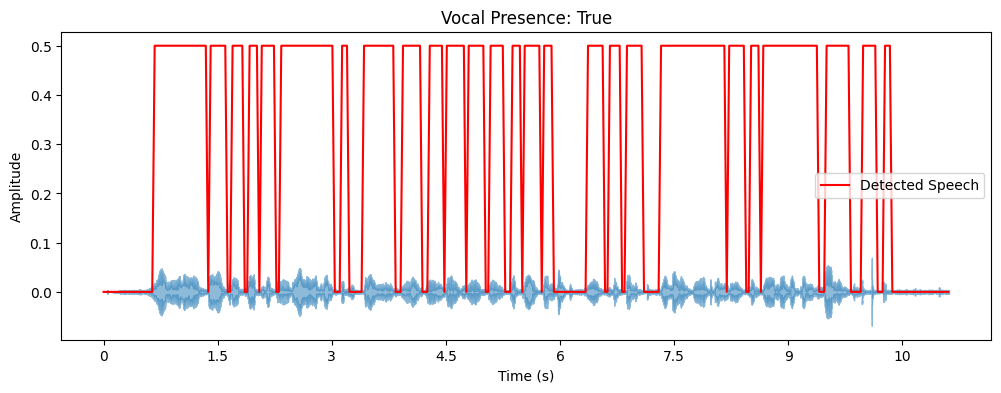

Vocal content detected: True


<ipython-input-14-11ec4b47c49a>:80: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=file_path)
<ipython-input-14-11ec4b47c49a>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-14-11ec4b47c49a>:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1

Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0001
   - Average RMS: 0.0068
   - Zero-Crossing Rate: 0.0406 (std: 0.0568)

2. Spectral Features:
   - Spectral Centroid: 976.94 Hz (std: 715.79)
   - Spectral Rolloff (85%): 1828.05 Hz
   - Energy Entropy: 0.0036

3. Performance Metrics:
   - Audio Duration: 11.10 seconds
   - Total Processing Time: 0.45 seconds
   - Real-Time Factor (RTF): 0.04
   - Processing Speed: 24.57x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/kashish_eng2.m4a'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/kashish_eng2.m4a')

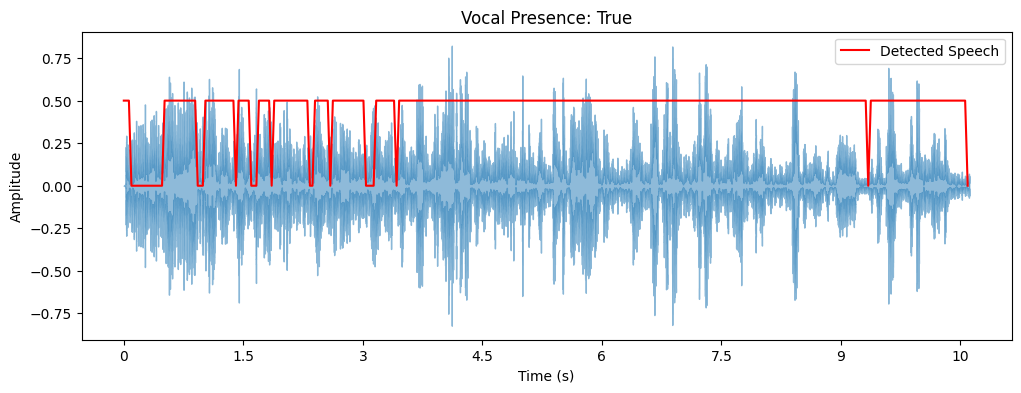

Vocal content detected: True
Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0164
   - Average RMS: 0.1145
   - Zero-Crossing Rate: 0.0177 (std: 0.0104)

2. Spectral Features:
   - Spectral Centroid: 397.23 Hz (std: 183.52)
   - Spectral Rolloff (85%): 791.94 Hz
   - Energy Entropy: 0.0000

3. Performance Metrics:
   - Audio Duration: 10.61 seconds
   - Total Processing Time: 0.11 seconds
   - Real-Time Factor (RTF): 0.01
   - Processing Speed: 99.49x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/Testing_Sample_Jasmine_1.wav'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/Testing_Sample_Jasmine_1.wav')

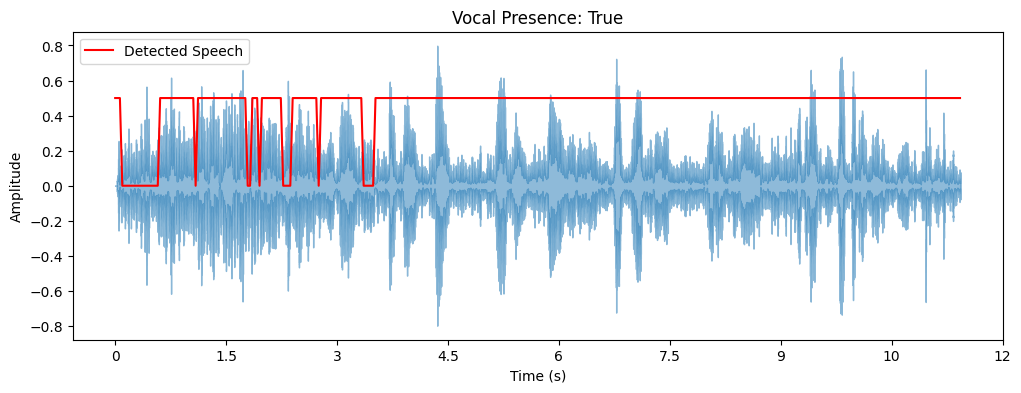

Vocal content detected: True
Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0141
   - Average RMS: 0.1077
   - Zero-Crossing Rate: 0.0223 (std: 0.0161)

2. Spectral Features:
   - Spectral Centroid: 533.31 Hz (std: 275.97)
   - Spectral Rolloff (85%): 1161.28 Hz
   - Energy Entropy: 0.0000

3. Performance Metrics:
   - Audio Duration: 11.43 seconds
   - Total Processing Time: 0.10 seconds
   - Real-Time Factor (RTF): 0.01
   - Processing Speed: 119.89x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/Testing_Sample_Jasime_2.wav'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/Testing_Sample_Jasime_2.wav')

<ipython-input-18-0ad31f8ac911>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-18-0ad31f8ac911>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-18-0ad31f8ac911>:42: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audiorea

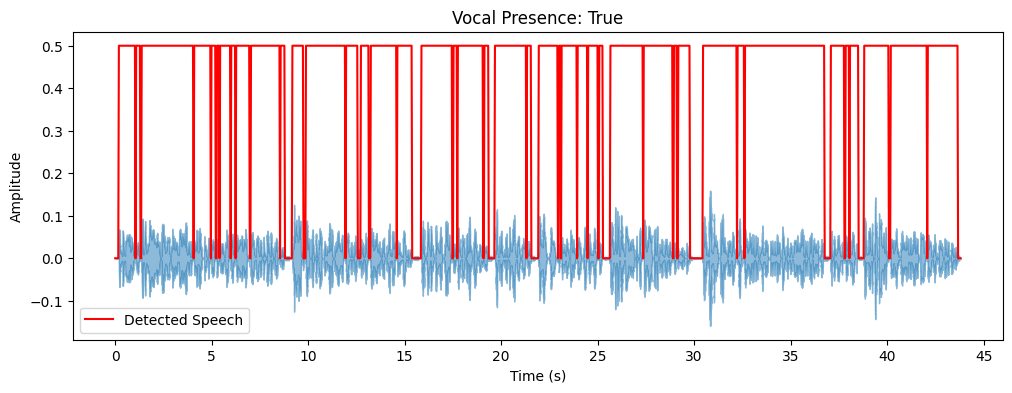

Vocal content detected: True


<ipython-input-18-0ad31f8ac911>:80: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=file_path)
<ipython-input-18-0ad31f8ac911>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-18-0ad31f8ac911>:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1

Basic Audio Properties Analysis:
1. Temporal Features:
   - Total Energy: 0.0003
   - Average RMS: 0.0135
   - Zero-Crossing Rate: 0.0424 (std: 0.0519)

2. Spectral Features:
   - Spectral Centroid: 787.95 Hz (std: 640.59)
   - Spectral Rolloff (85%): 1382.53 Hz
   - Energy Entropy: 0.0037

3. Performance Metrics:
   - Audio Duration: 43.80 seconds
   - Total Processing Time: 0.76 seconds
   - Real-Time Factor (RTF): 0.02
   - Processing Speed: 58.00x real-time


In [ ]:
def detect_vocal_presence(file_path, vad_aggressiveness=3, silence_threshold=-40, min_silence_duration=0.3):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    vad = webrtcvad.Vad(vad_aggressiveness)

    y_int16 = (y * 32767).astype(np.int16)

    frame_duration = 30
    frames = []
    for i in range(0, len(y_int16), int(sr * frame_duration / 1000)):
        frame = y_int16[i:i+int(sr * frame_duration/1000)]
        if len(frame) < 480:
            break
        frames.append(frame)

    speech_frames = [vad.is_speech(frame.tobytes(), sr) for frame in frames]

    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    db_rms = librosa.amplitude_to_db(rms, ref=np.max)
    energy_speech = db_rms > silence_threshold

    final_speech = np.zeros_like(times, dtype=bool)
    for i, t in enumerate(times):
        frame_index = int(t * 1000 / frame_duration)
        if frame_index < len(speech_frames):
            final_speech[i] = speech_frames[frame_index] and energy_speech[i]

    speech_duration = np.sum(final_speech) * (times[1] - times[0])
    return speech_duration > 0.5, final_speech, times

file_name = '/content/audio1.m4a'

has_vocals, speech_mask, times = detect_vocal_presence(file_name)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa.load(file_name, sr=None)[0], sr=librosa.get_samplerate(file_name), alpha=0.5)
plt.plot(times, speech_mask * 0.5, 'r', label='Detected Speech')
plt.title(f'Vocal Presence: {has_vocals}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Vocal content detected: {has_vocals}")

def audio_property_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True)

    energy = np.sum(y**2) / len(y)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)[0]


    rms = librosa.feature.rms(y=y)[0]
    energy_entropy = librosa.feature.spectral_flatness(y=y)

    print(f"Basic Audio Properties Analysis:")
    print(f"1. Temporal Features:")
    print(f"   - Total Energy: {energy:.4f}")
    print(f"   - Average RMS: {np.mean(rms):.4f}")
    print(f"   - Zero-Crossing Rate: {np.mean(zcr):.4f} (std: {np.std(zcr):.4f})")

    print(f"\n2. Spectral Features:")
    print(f"   - Spectral Centroid: {np.mean(spectral_centroid):.2f} Hz (std: {np.std(spectral_centroid):.2f})")
    print(f"   - Spectral Rolloff (85%): {np.mean(spectral_rolloff):.2f} Hz")
    print(f"   - Energy Entropy: {np.mean(energy_entropy):.4f}")



def measure_latency(file_path):
    duration = librosa.get_duration(path=file_path)

    start_time = time.time()

    has_vocals, _, _ = detect_vocal_presence(file_path)

    audio_property_analysis(file_path)

    processing_time = time.time() - start_time
    real_time_factor = processing_time / duration

    print(f"\n3. Performance Metrics:")
    print(f"   - Audio Duration: {duration:.2f} seconds")
    print(f"   - Total Processing Time: {processing_time:.2f} seconds")
    print(f"   - Real-Time Factor (RTF): {real_time_factor:.2f}")
    print(f"   - Processing Speed: {duration/processing_time:.2f}x real-time")

measure_latency('/content/audio1.m4a')

In [ ]:
print("\nIdeal Feature Ranges for Vocal Detection:")
print("| Feature               | Voiced Speech      | Unvoiced/Silence   | Source     |")
print("|-----------------------|--------------------|--------------------|------------|")
print("| Zero Crossing Rate    | <0.1               | >0.3               | [6][9][10] |")
print("| Spectral Centroid (Hz)| 500-4000           | <500 or >4000      | [1][2][7]  |")
print("| RMS Energy (dB)       | >-40 (normalized)  | <-40               | [5][8]     |")
print("| Spectral Rolloff (Hz) | 2000-5000          | <2000              | [3][4]     |")
print("| Temporal Modulation   | 4-16 Hz dominant   | Random distribution| [4]        |")


Ideal Feature Ranges for Vocal Detection:
| Feature               | Voiced Speech      | Unvoiced/Silence   | Source     |
|-----------------------|--------------------|--------------------|------------|
| Zero Crossing Rate    | <0.1               | >0.3               | [6][9][10] |
| Spectral Centroid (Hz)| 500-4000           | <500 or >4000      | [1][2][7]  |
| RMS Energy (dB)       | >-40 (normalized)  | <-40               | [5][8]     |
| Spectral Rolloff (Hz) | 2000-5000          | <2000              | [3][4]     |
| Temporal Modulation   | 4-16 Hz dominant   | Random distribution| [4]        |


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def feature_contribution_analysis(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Temporal Features
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512)[0]
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Spectral Features
    S = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(S=S, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)[0]

    # Visualization
    plt.figure(figsize=(15, 10))

    # Temporal Features Plot
    plt.subplot(3,1,1)
    plt.plot(times, zcr, label='ZCR')
    plt.plot(times, rms/np.max(rms), label='Normalized RMS')
    plt.axhline(0.1, c='r', linestyle='--', label='Voiced Threshold [6][10]')
    plt.axhline(0.3, c='g', linestyle='--', label='Unvoiced Threshold [6][10]')
    plt.ylabel('Normalized Values')
    plt.title('Temporal Features Analysis')
    plt.legend()

    # Spectral Features Plot
    plt.subplot(3,1,2)
    plt.plot(times, spectral_centroid, label='Spectral Centroid')
    plt.plot(times, spectral_rolloff, label='Spectral Rolloff (85%)')
    plt.axhline(500, c='r', linestyle='--', label='Speech Lower Bound [1][7]')
    plt.axhline(4000, c='g', linestyle='--', label='Speech Upper Bound [1][7]')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectral Features Analysis')
    plt.legend()

    # Combined Feature Space
    plt.subplot(3,1,3)
    plt.scatter(spectral_centroid, zcr, c=rms, cmap='viridis')
    plt.colorbar(label='RMS Energy [5][8]')
    plt.xlabel('Spectral Centroid (Hz) [2][7]')
    plt.ylabel('Zero Crossing Rate [6][9]')
    plt.title('Feature Interaction Space')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

<ipython-input-22-5fb47a3371dd>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


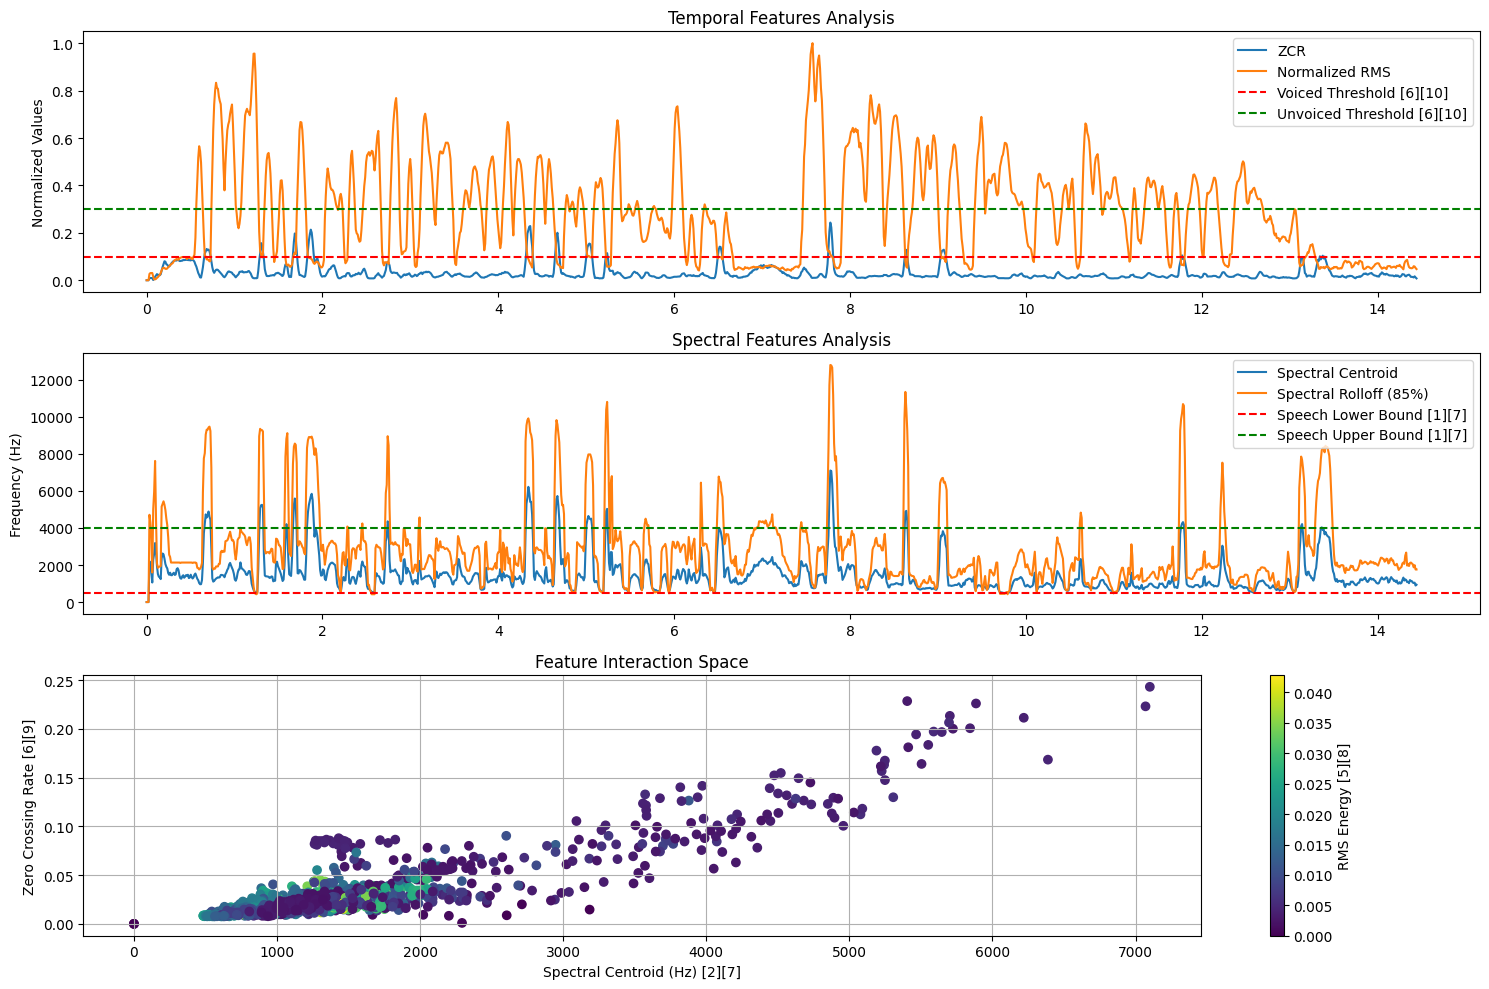

In [ ]:
feature_contribution_analysis('/content/friend_eng1.m4a')

<ipython-input-22-5fb47a3371dd>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


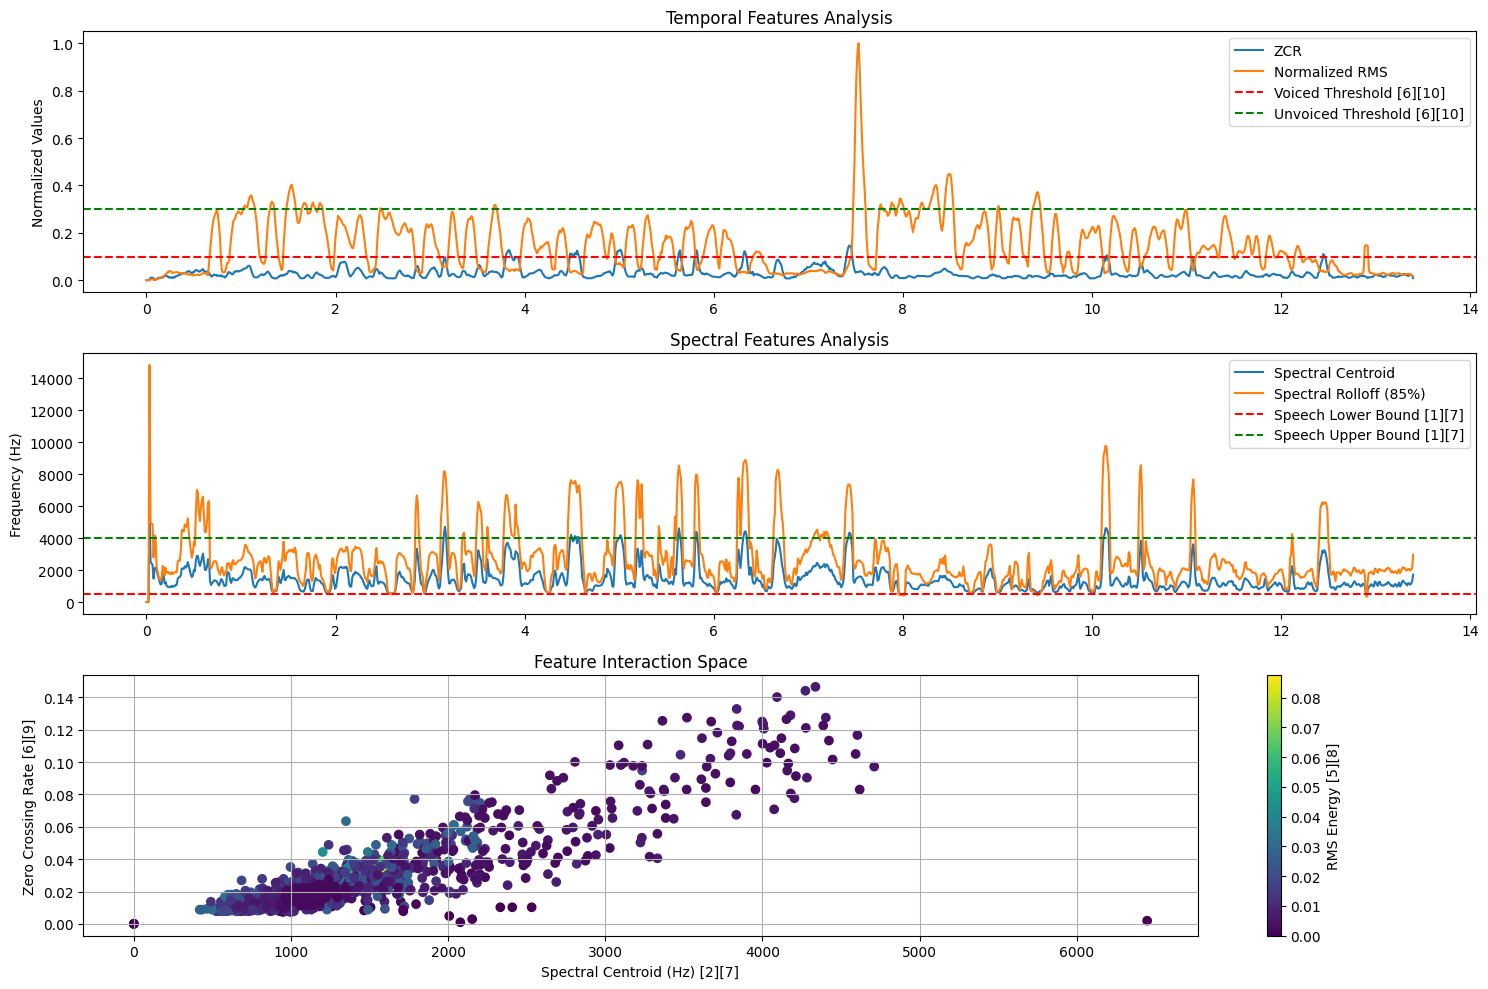

In [ ]:
feature_contribution_analysis('/content/friend_eng2.m4a')

<ipython-input-22-5fb47a3371dd>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


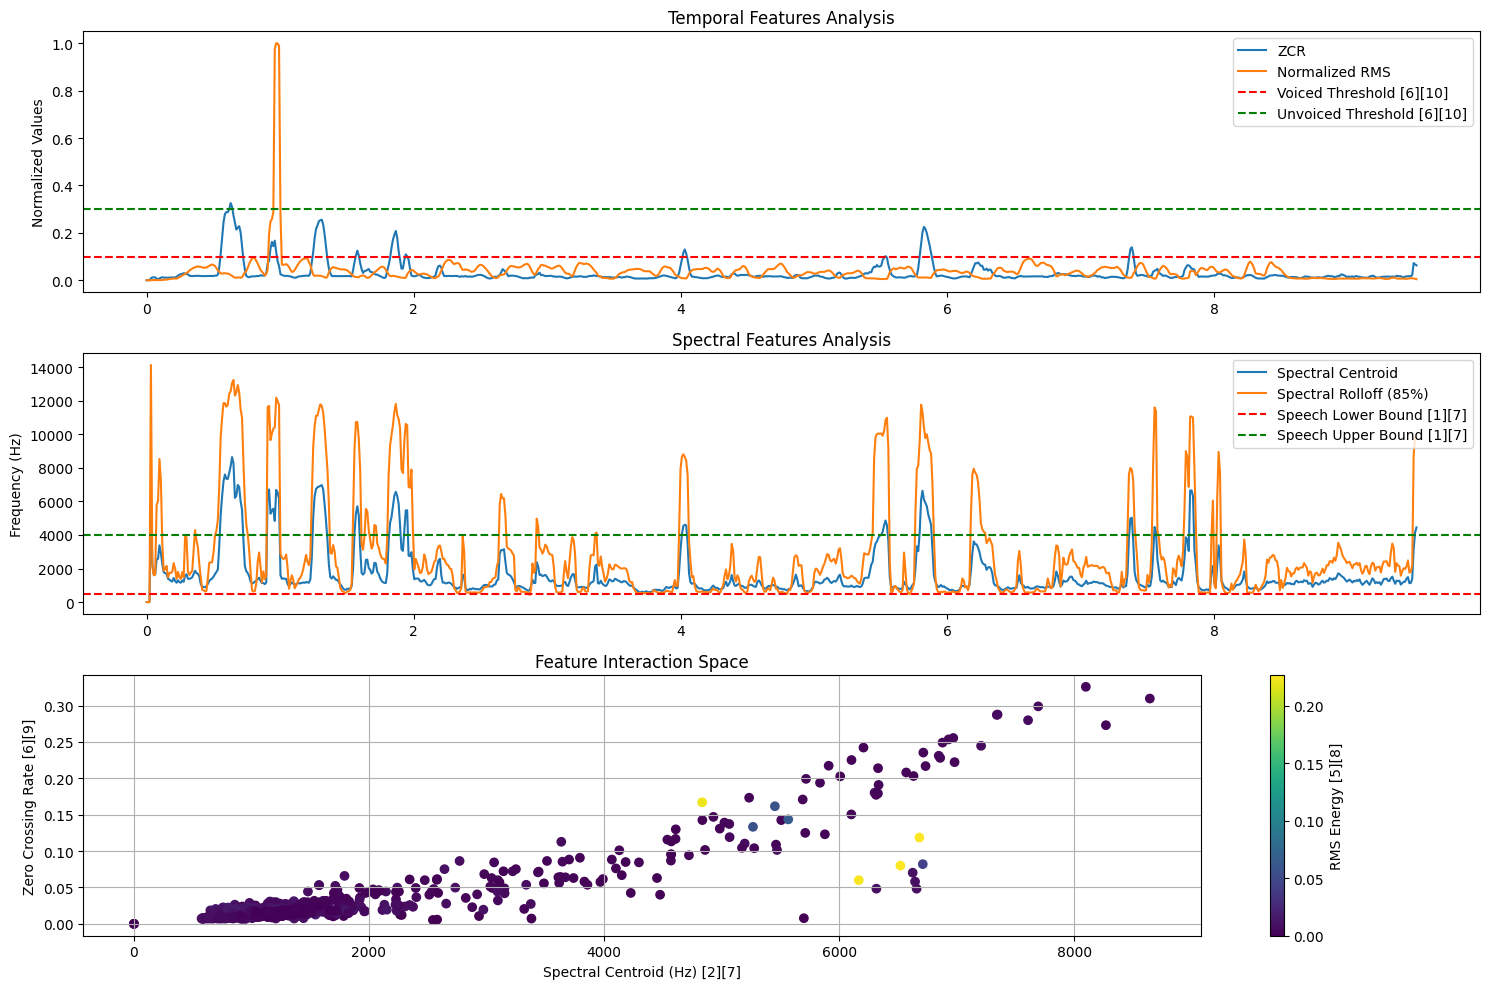

In [ ]:
feature_contribution_analysis('/content/kashish_eng1.m4a')

<ipython-input-22-5fb47a3371dd>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


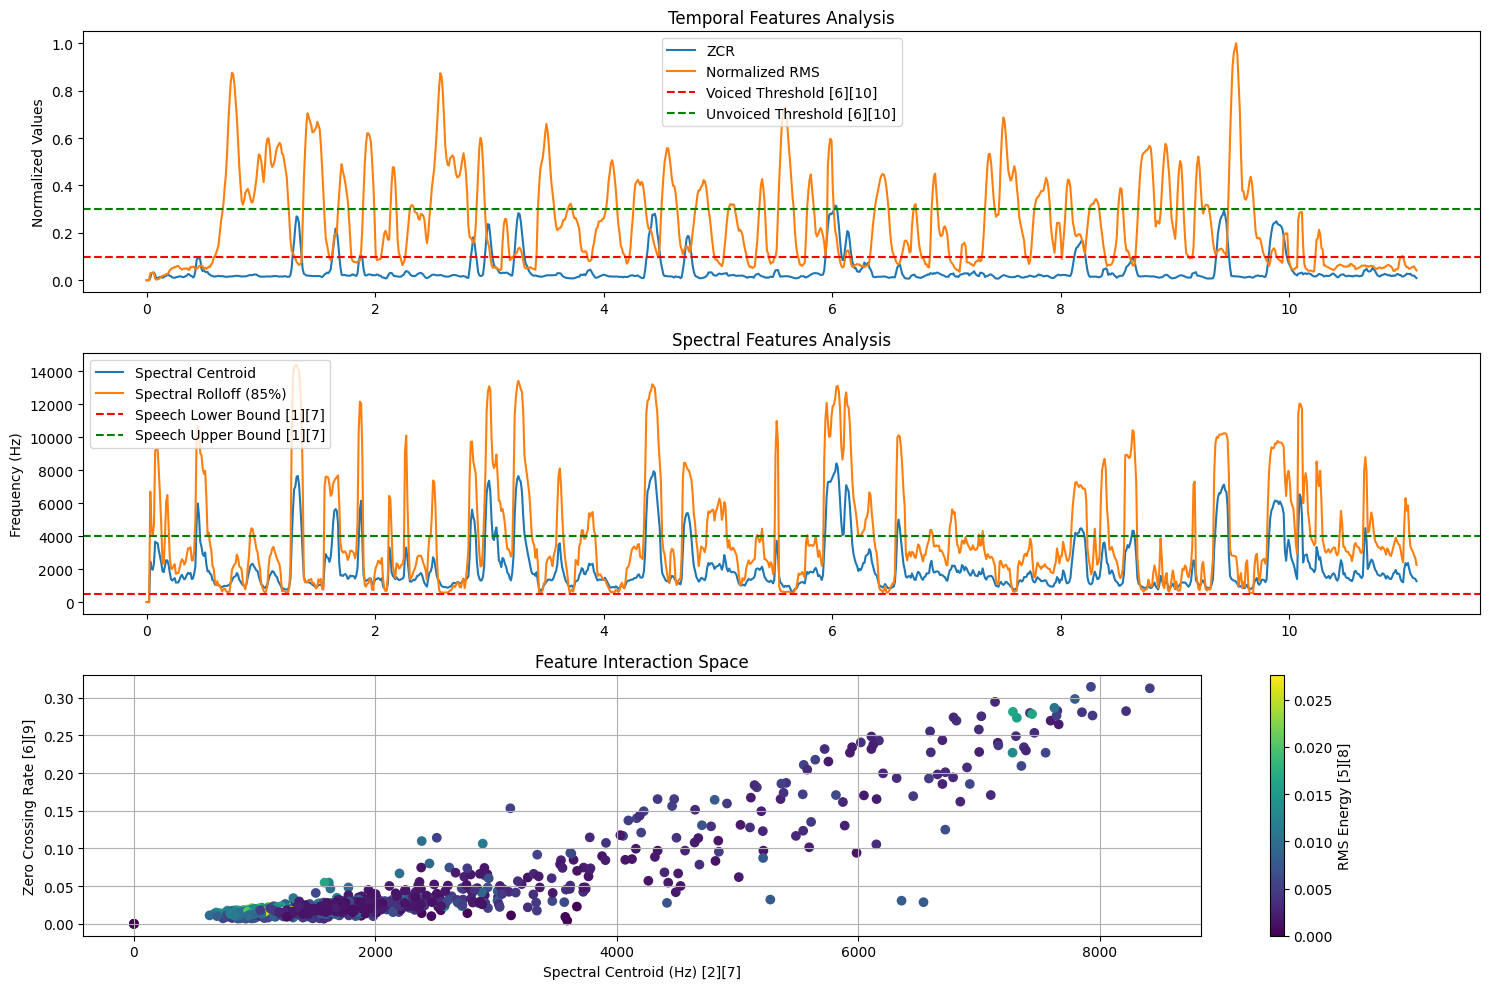

In [ ]:
feature_contribution_analysis('/content/kashish_eng2.m4a')

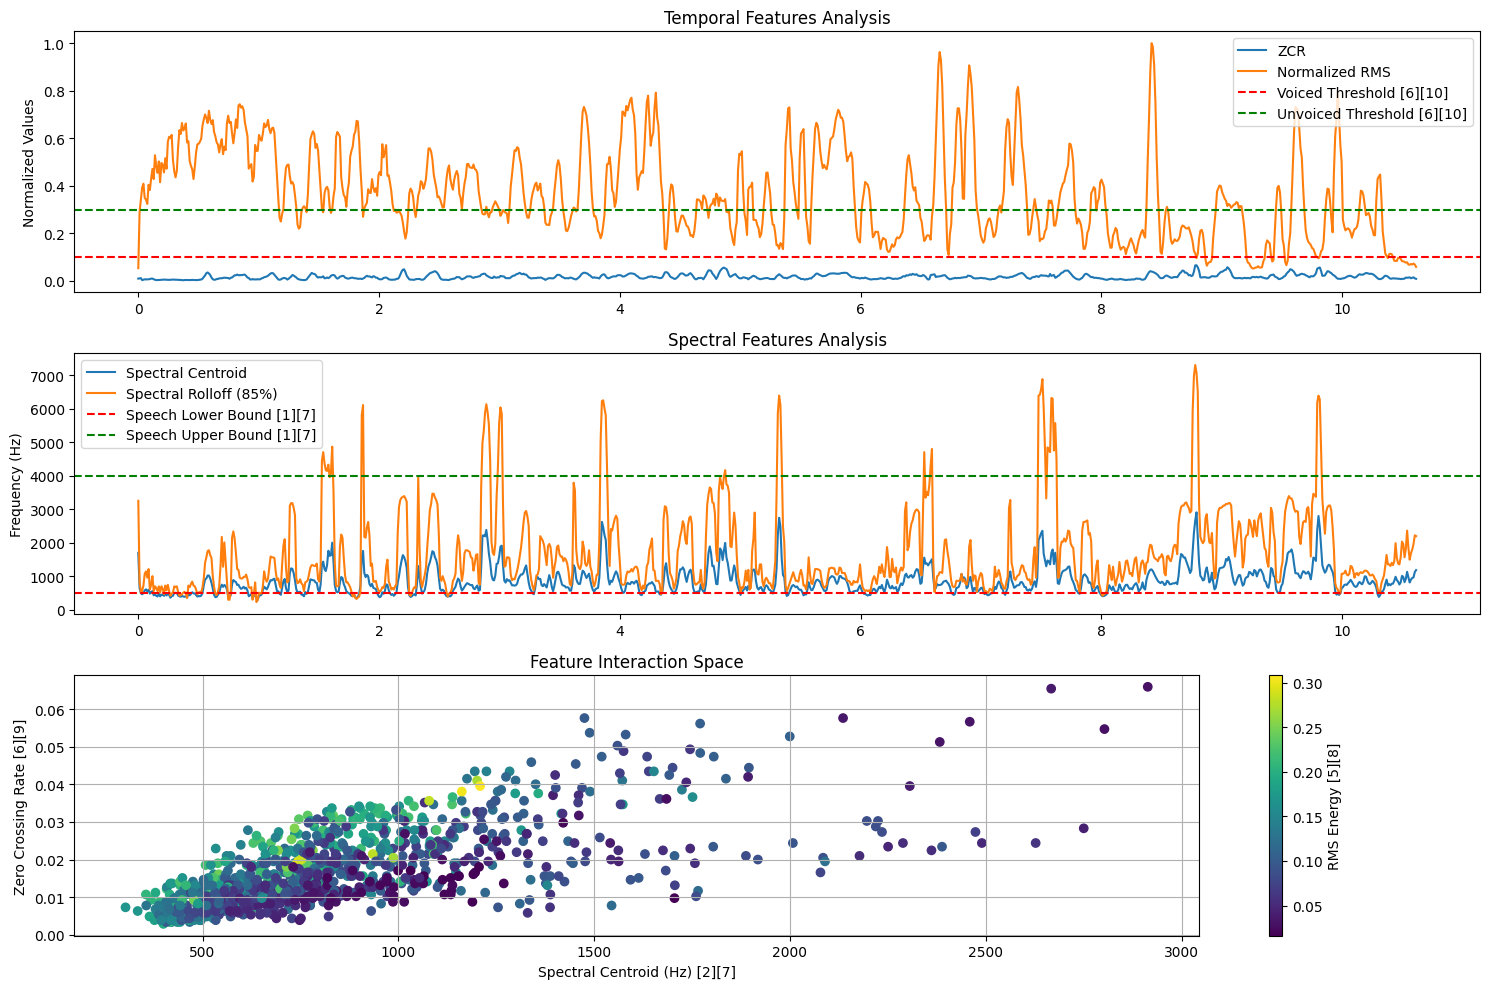

In [ ]:
feature_contribution_analysis('/content/Testing_Sample_Jasmine_1.wav')

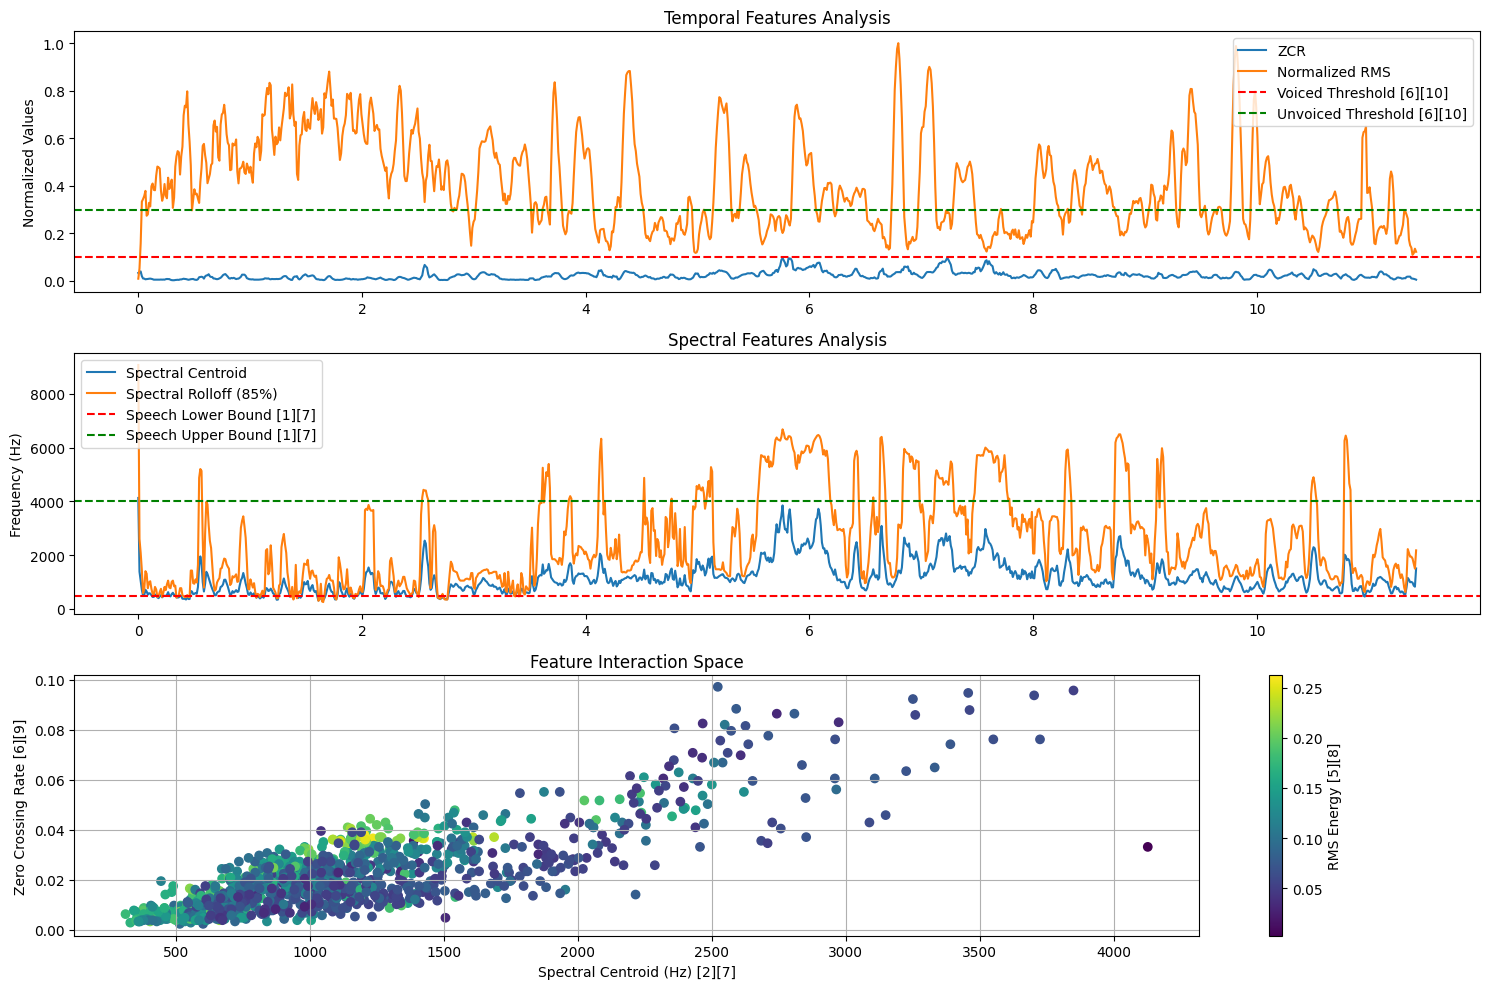

In [ ]:
feature_contribution_analysis('/content/Testing_Sample_Jasime_2.wav')

<ipython-input-22-5fb47a3371dd>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


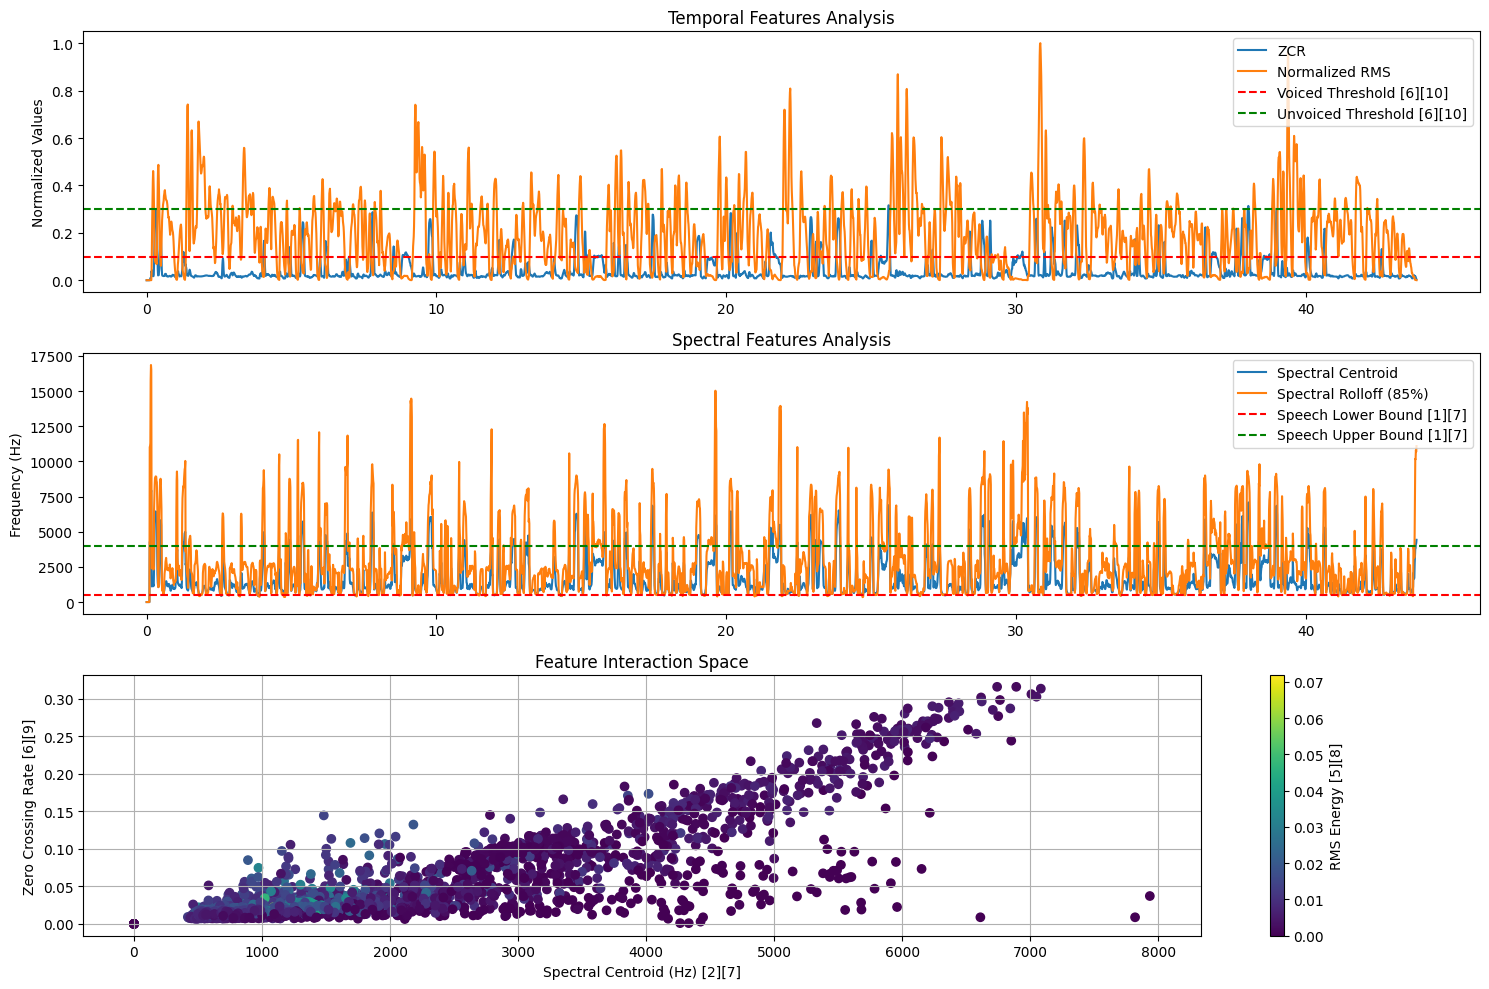

In [ ]:
feature_contribution_analysis('/content/audio1.m4a')

Analyzing audio file: /content/friend_eng1.m4a


<ipython-input-1-0830ad504f35>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


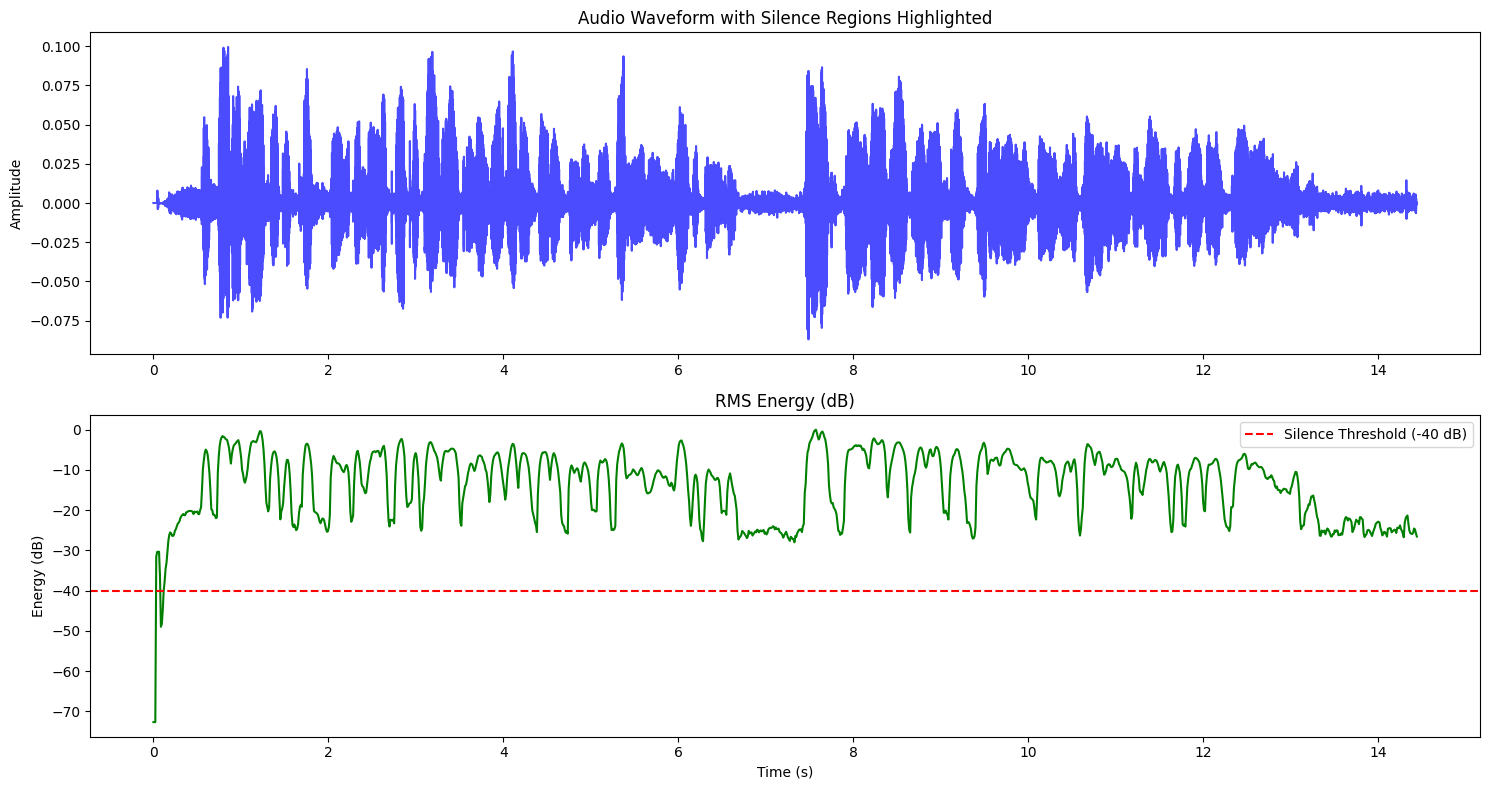


--- Analysis Results ---
Total Duration: 14.44 seconds
Speech Detected: 100.0% (14.44 seconds)
Silence Detected: 0.0% (0.00 seconds)
Analysis completed in 16.04 seconds (RTF: 1.110)


In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/friend_eng1.m4a')


Analyzing audio file: /content/friend_eng2.m4a


<ipython-input-2-c682b2df6df3>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


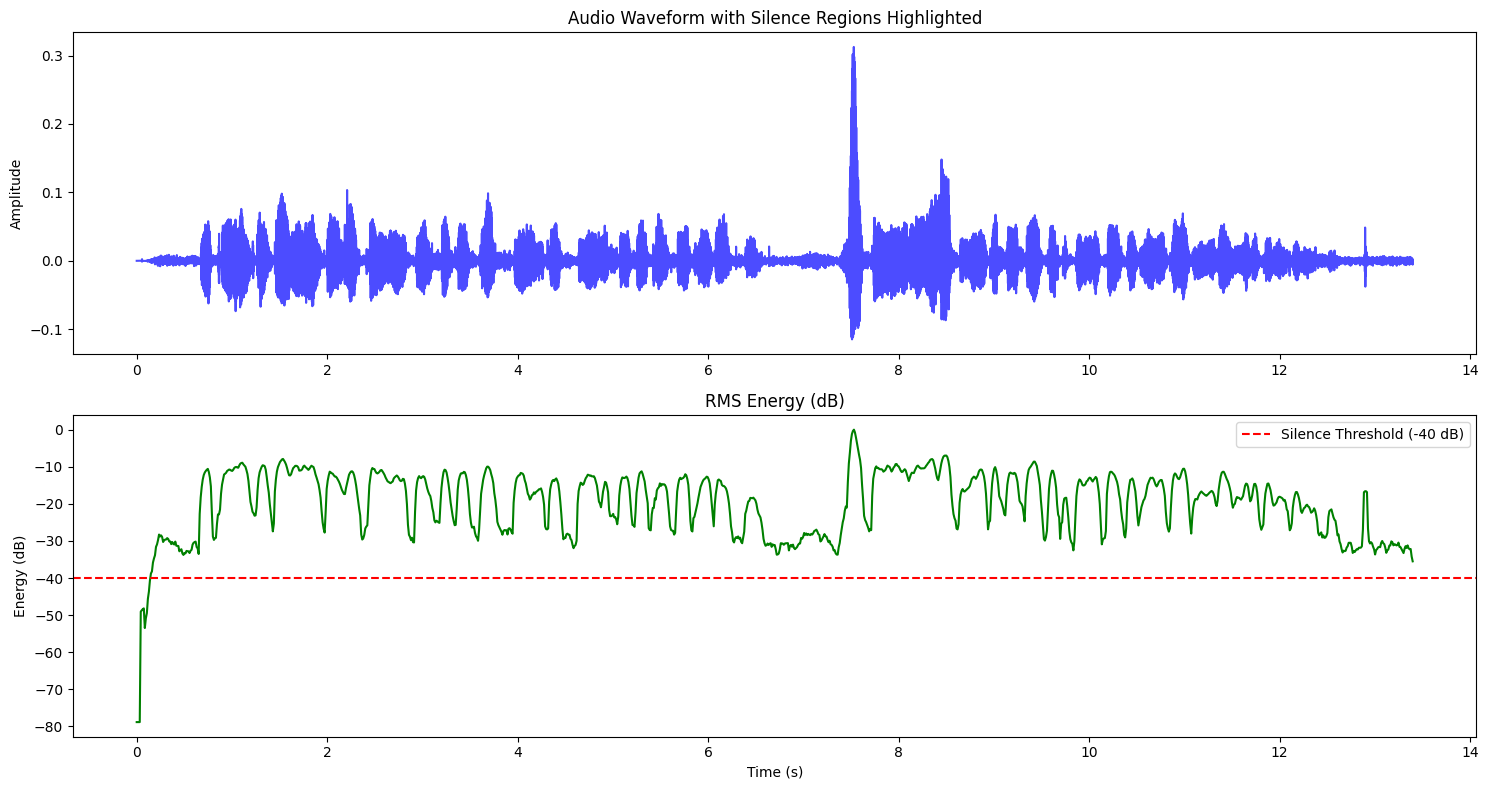


--- Analysis Results ---
Total Duration: 13.40 seconds
Speech Detected: 100.0% (13.40 seconds)
Silence Detected: 0.0% (0.00 seconds)
Analysis completed in 0.82 seconds (RTF: 0.061)


In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/friend_eng2.m4a')

Analyzing audio file: /content/kashish_eng1.m4a


<ipython-input-3-65ba0bcc0161>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


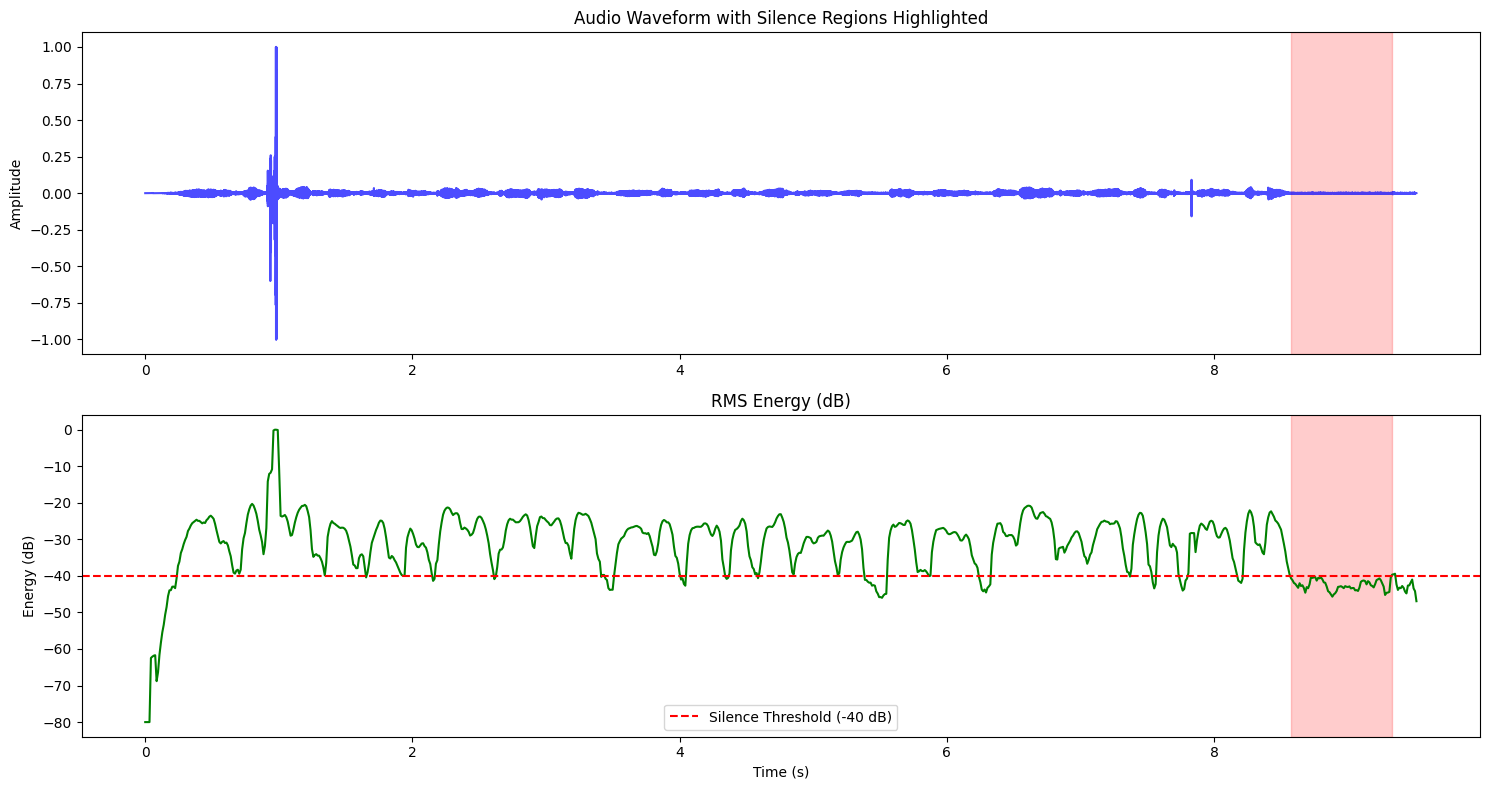


--- Analysis Results ---
Total Duration: 9.51 seconds
Speech Detected: 92.0% (8.76 seconds)
Silence Detected: 8.0% (0.76 seconds)
Analysis completed in 0.50 seconds (RTF: 0.052)


In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/kashish_eng1.m4a')

Analyzing audio file: /content/kashish_eng2.m4a


<ipython-input-4-574ff57e51ee>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


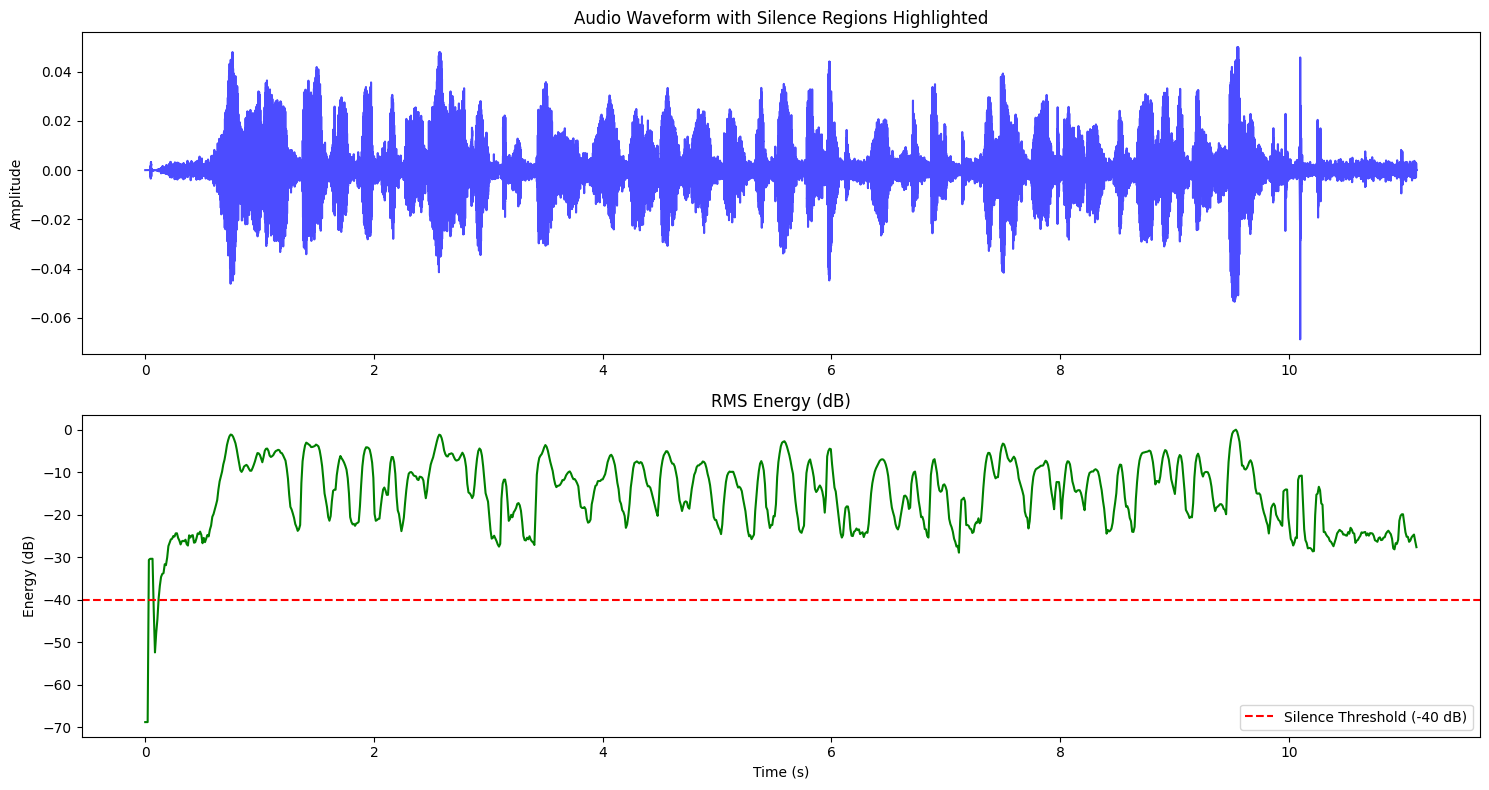


--- Analysis Results ---
Total Duration: 11.11 seconds
Speech Detected: 100.0% (11.11 seconds)
Silence Detected: 0.0% (0.00 seconds)
Analysis completed in 0.62 seconds (RTF: 0.056)


In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/kashish_eng2.m4a')

Analyzing audio file: /content/Testing_Sample_Jasime_2.wav


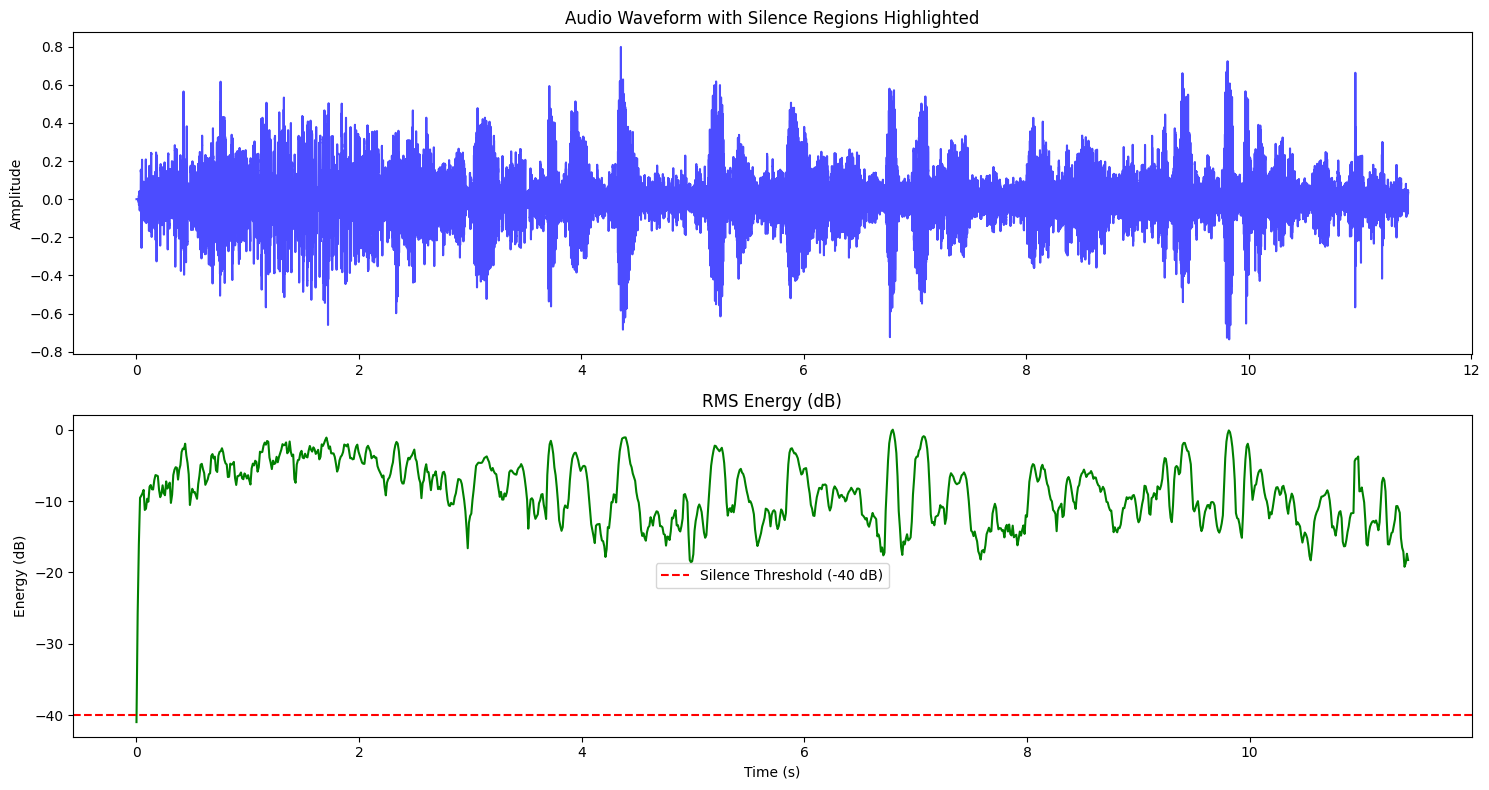


--- Analysis Results ---
Total Duration: 11.43 seconds
Speech Detected: 100.0% (11.43 seconds)
Silence Detected: 0.0% (0.00 seconds)
Analysis completed in 0.56 seconds (RTF: 0.049)


In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/Testing_Sample_Jasime_2.wav')


Analyzing audio file: /content/Testing_Sample_Jasmine_1.wav


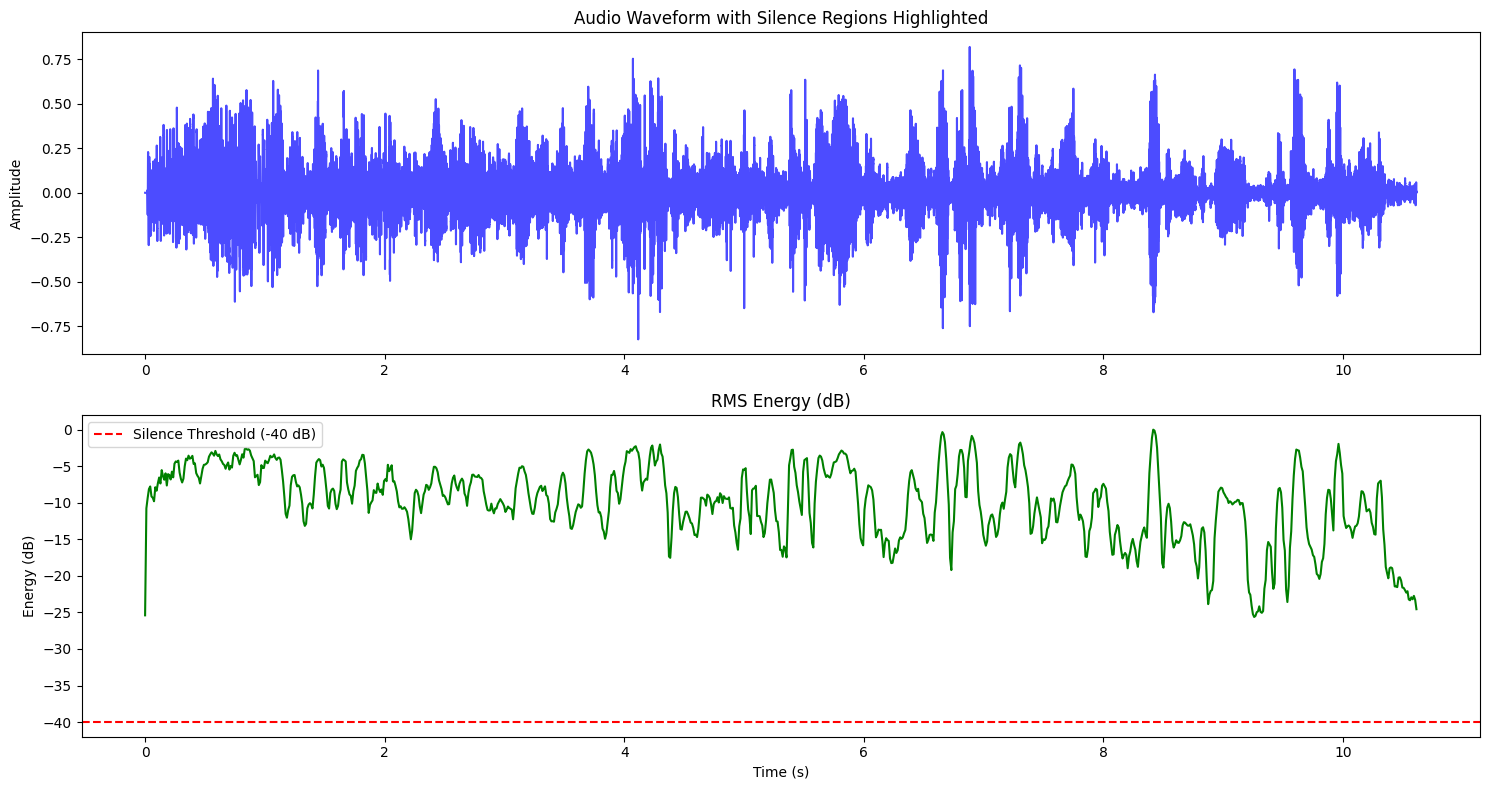


--- Analysis Results ---
Total Duration: 10.61 seconds
Speech Detected: 100.0% (10.61 seconds)
Silence Detected: 0.0% (0.00 seconds)
Analysis completed in 0.47 seconds (RTF: 0.044)


In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/Testing_Sample_Jasmine_1.wav')


Analyzing audio file: /content/audio1.m4a


<ipython-input-7-100156a74367>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


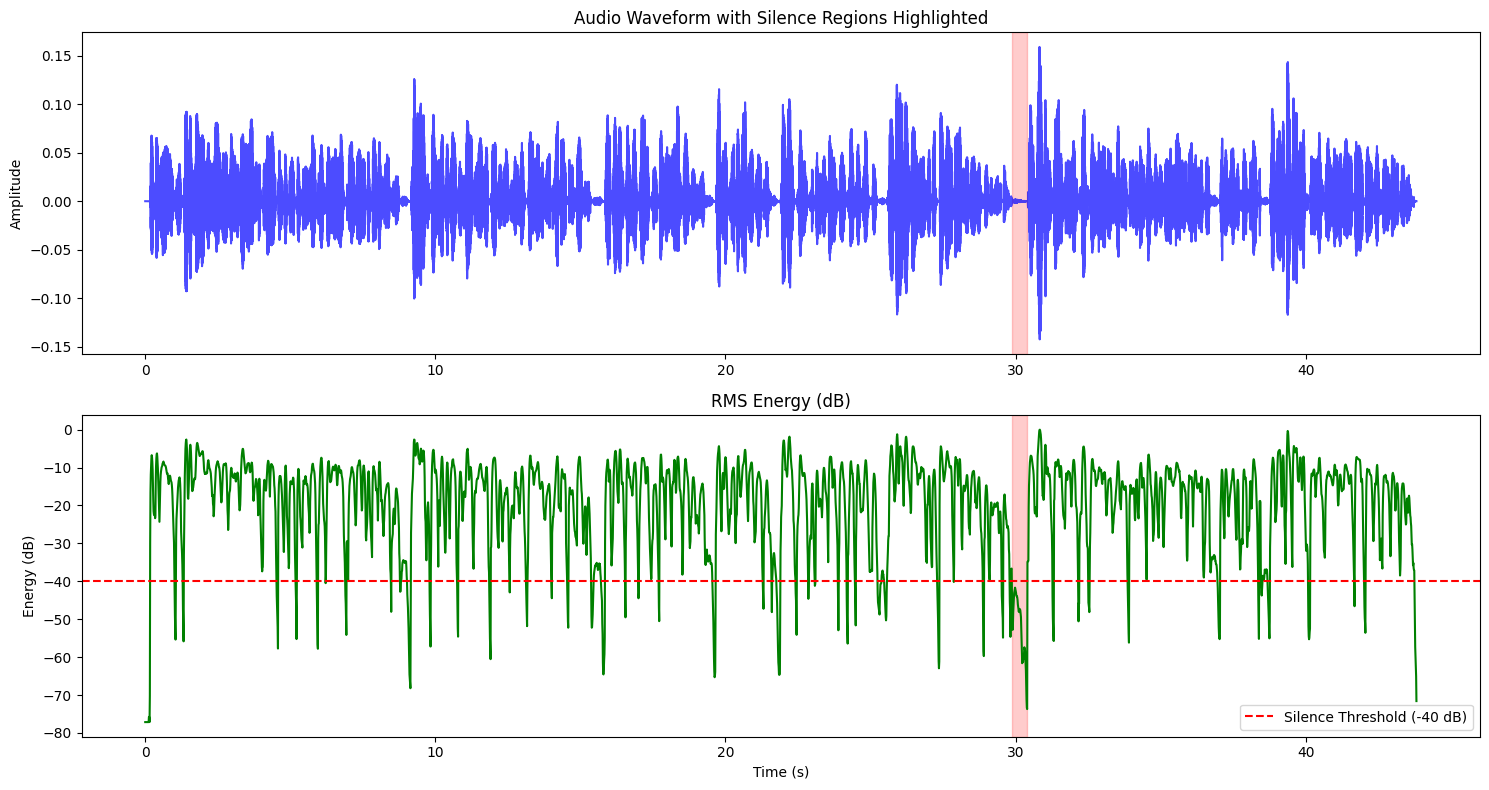


--- Analysis Results ---
Total Duration: 43.82 seconds
Speech Detected: 98.8% (43.29 seconds)
Silence Detected: 1.2% (0.53 seconds)
Analysis completed in 0.98 seconds (RTF: 0.022)


In [7]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time

def measure_speech_silence_percentages(file_path, silence_threshold_db=-40, min_silence_duration=0.3):
    """
    Calculate the percentage of speech vs silence in an audio file.

    Parameters:
        file_path: Path to audio file
        silence_threshold_db: Energy threshold in dB below which is considered silence
        min_silence_duration: Minimum length in seconds to count as a silence region
    """
    print(f"Analyzing audio file: {file_path}")
    start_time = time.time()

    # Load audio with original sampling rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate RMS energy and convert to dB
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
    db_rms = librosa.amplitude_to_db(rms, ref=np.max)

    # Create silence mask where energy falls below threshold
    silence_mask = db_rms < silence_threshold_db

    # Remove short silence segments using minimum duration requirement
    hop_duration = 512 / sr  # Duration of each frame in seconds
    frame_times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Find continuous silence regions
    silence_regions = []
    in_silence = False
    silence_start = 0

    for i, is_silence in enumerate(silence_mask):
        # Silence start
        if is_silence and not in_silence:
            in_silence = True
            silence_start = i
        # Silence end
        elif not is_silence and in_silence:
            in_silence = False
            silence_duration = (i - silence_start) * hop_duration
            if silence_duration >= min_silence_duration:
                silence_regions.append((silence_start, i))

    # Handle case where file ends during silence
    if in_silence:
        silence_duration = (len(silence_mask) - silence_start) * hop_duration
        if silence_duration >= min_silence_duration:
            silence_regions.append((silence_start, len(silence_mask)))

    # Calculate total silence duration
    silence_duration = sum([(end - start) * hop_duration for start, end in silence_regions])
    speech_duration = duration - silence_duration

    # Calculate percentages
    silence_percentage = (silence_duration / duration) * 100
    speech_percentage = (speech_duration / duration) * 100

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    times = np.linspace(0, duration, len(y))
    plt.plot(times, y, color='blue', alpha=0.7)

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                    color='red', alpha=0.2)

    plt.title("Audio Waveform with Silence Regions Highlighted")
    plt.ylabel("Amplitude")

    # Plot energy levels
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, db_rms, color='green')
    plt.axhline(y=silence_threshold_db, color='red', linestyle='--',
                label=f'Silence Threshold ({silence_threshold_db} dB)')

    # Shade silence regions
    for start, end in silence_regions:
        plt.axvspan(frame_times[start], frame_times[end],
                   color='red', alpha=0.2)

    plt.title("RMS Energy (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print results
    processing_time = time.time() - start_time
    print(f"\n--- Analysis Results ---")
    print(f"Total Duration: {duration:.2f} seconds")
    print(f"Speech Detected: {speech_percentage:.1f}% ({speech_duration:.2f} seconds)")
    print(f"Silence Detected: {silence_percentage:.1f}% ({silence_duration:.2f} seconds)")
    print(f"Analysis completed in {processing_time:.2f} seconds (RTF: {processing_time/duration:.3f})")

    return {
        "speech_percentage": speech_percentage,
        "silence_percentage": silence_percentage,
        "speech_duration": speech_duration,
        "silence_duration": silence_duration,
        "total_duration": duration
    }

# Run the analysis
results = measure_speech_silence_percentages('/content/audio1.m4a')